In [34]:
import warnings
# Ignore specific TensorFlow warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")
warnings.filterwarnings("ignore", category=FutureWarning, module="tensorflow")

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

***
# Data Preparation
***

### Dataset Importing: 

In [3]:
dataset_path = "C:/Users/sanab/Desktop/chest_xray/"

In [4]:
os.listdir(dataset_path)

['chest_xray', 'test', 'train', 'val', '__MACOSX']

### Dataset Discovery:


In [5]:
#Count the images in each category of our splits
directories = ['train', 'test', 'val']
#Dictionary to store the counts for each split
split_counts = {}
for sub_dir in directories:
    directory_path = os.path.join(dataset_path,sub_dir)
    #Count NORMAL images
    normal_path = os.path.join(directory_path, 'NORMAL')
    count_normal = len(os.listdir(normal_path))
    #Count PNEUMONIA images
    pneumonia_path = os.path.join(directory_path, 'PNEUMONIA')
    count_pneumonia = len(os.listdir(pneumonia_path))
    #Print the counts of each sub-directory
    print(f"The {sub_dir} set , Normal images: {count_normal}, Pneumonia images: {count_pneumonia}")
    #Store the counts for Viz
    split_counts[sub_dir] = {'Normal': count_normal, 'Pneumonia': count_pneumonia}
    #Calculate the total number of images for each subset
    total_imgs= count_normal + count_pneumonia
    print(f"Number of images in {sub_dir} set: {total_imgs}\n")

The train set , Normal images: 1341, Pneumonia images: 3875
Number of images in train set: 5216

The test set , Normal images: 234, Pneumonia images: 390
Number of images in test set: 624

The val set , Normal images: 8, Pneumonia images: 8
Number of images in val set: 16



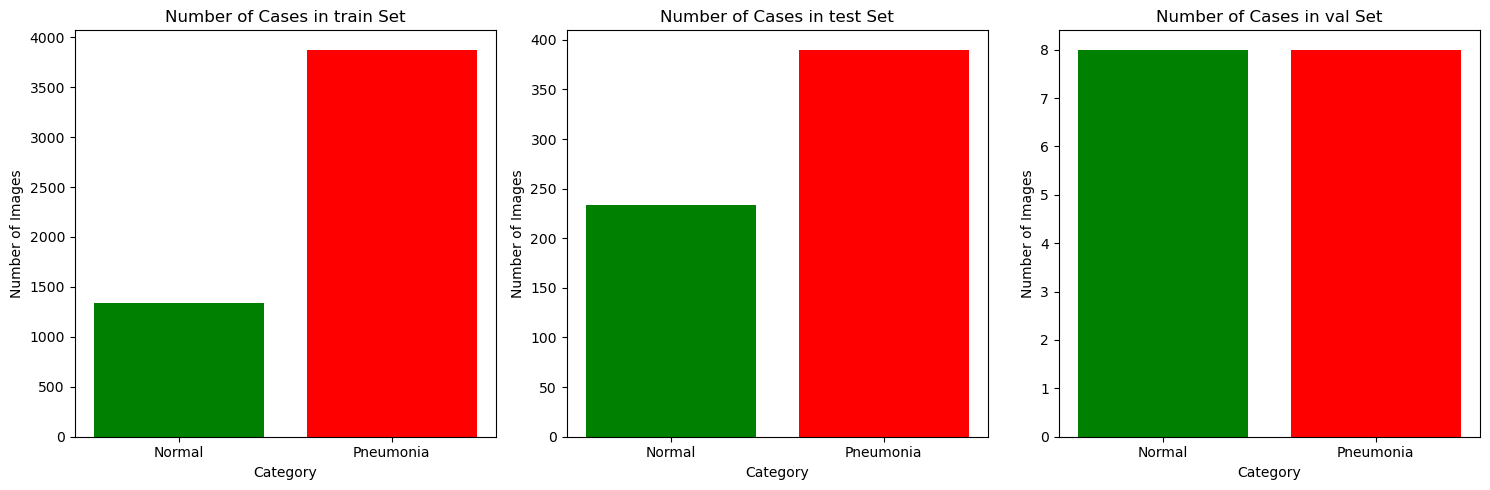

In [6]:
#Visualize results of each split
fig, axes = plt.subplots(1, len(split_counts), figsize=(15,5))
#Iterate through each sub-directory
for i, (sub_dir, counts) in enumerate(split_counts.items()):
#Extracts the categories from the counts dict and converts them to a list
    categories = list(counts.keys())
    values = list(counts.values()) #nbr of images
    #Use the i-th subplot
    axes[i].bar(categories, values, color=['green', 'red'])
    axes[i].set_title(f"Number of Cases in {sub_dir} Set")
    axes[i].set_xlabel("Category")
    axes[i].set_ylabel("Number of Images")
# Adjust layout and show the plots
plt.tight_layout()
plt.show()

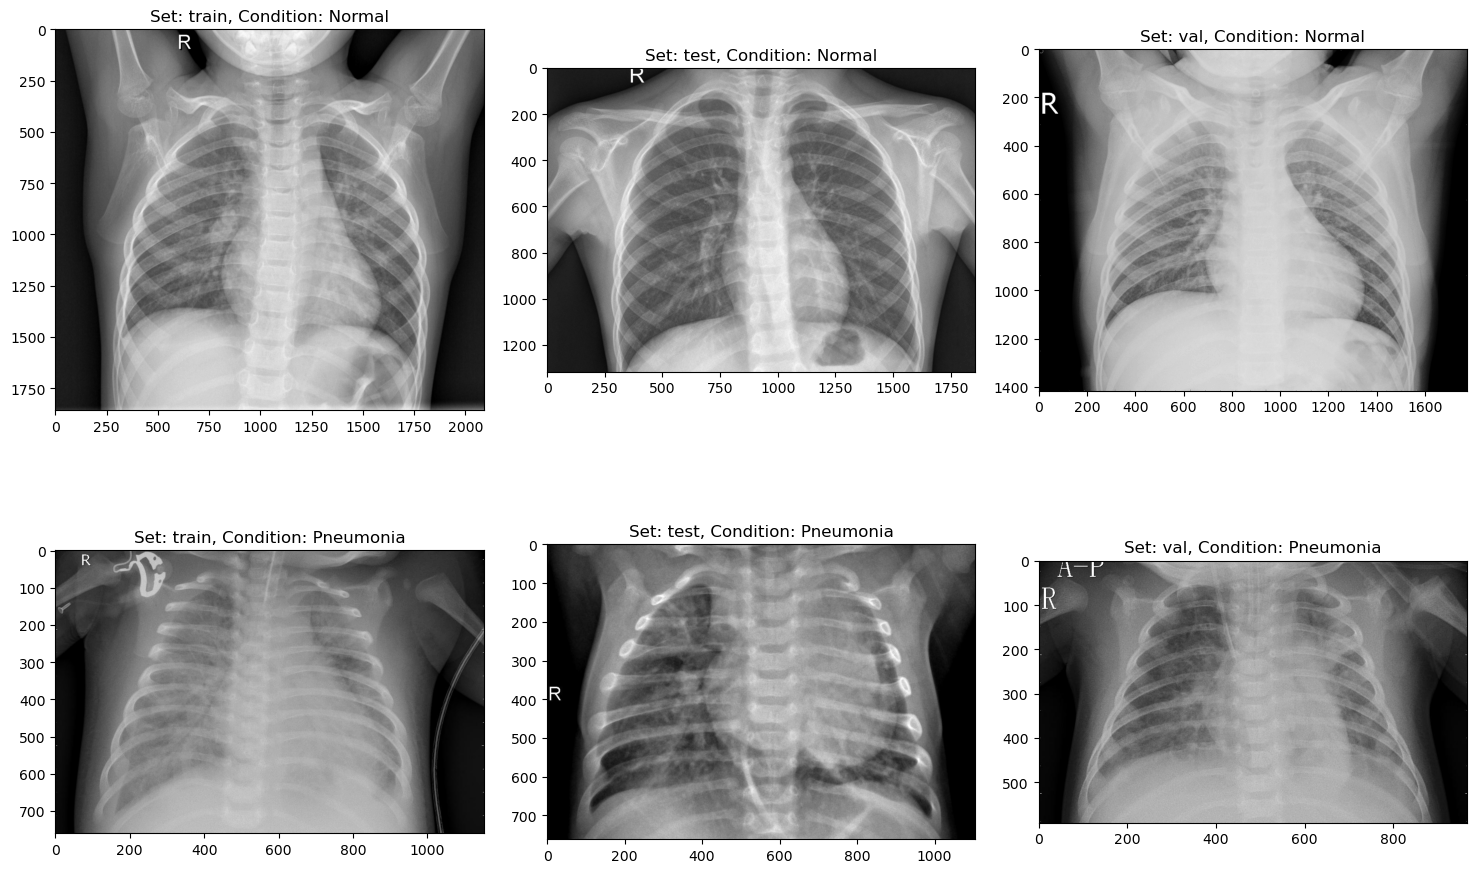

In [7]:
#Preview of the dataset
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, sub_dir in enumerate(directories):
    set_path = dataset_path + sub_dir
    axes[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0]), cmap="gray")
    axes[i].set_title("Set: {}, Condition: Normal".format(sub_dir))
    axes[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0]), cmap="gray")
    axes[i+3].set_title('Set: {}, Condition: Pneumonia'.format(sub_dir))
#Adjust the layout and display images by set and category
plt.tight_layout()
plt.show()

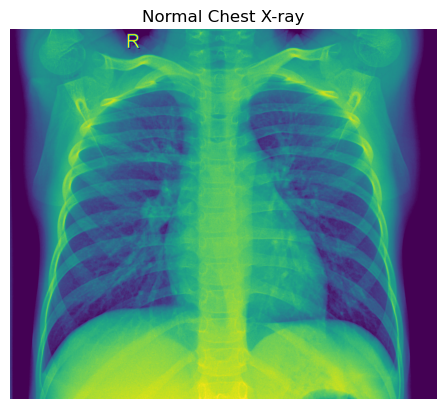

	 Normal Image Width: 2338 pixels
	 Normal Image Height: 2025 pixels


In [8]:
#EXAMPLE1
image_path ='C:/Users/sanab/Desktop/chest_xray/train/NORMAL/IM-0183-0001.jpeg'
image_N = mpimg.imread(image_path)
plt.imshow(image_N)
plt.title("Normal Chest X-ray")
plt.axis('off')
plt.show()
#Get Normal image dimensions
height, width = image_N.shape
print(f"\t Normal Image Width: {width} pixels")
print(f"\t Normal Image Height: {height} pixels")

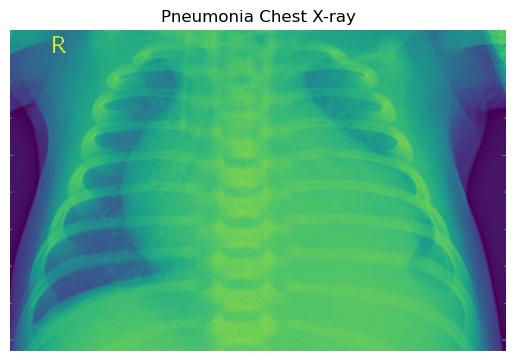

	 Pneumonia Image Width: 840 pixels
	 Pneumonia Image Height: 544 pixels


In [9]:
#EXAMPLE2
image_path ='C:/Users/sanab/Desktop/chest_xray/train/PNEUMONIA/person27_bacteria_137.jpeg'
image_P = mpimg.imread(image_path)
plt.imshow(image_P)
plt.title("Pneumonia Chest X-ray")
plt.axis('off')
plt.show()
#Get Pneumonia image dimensions
height, width = image_P.shape
print(f"\t Pneumonia Image Width: {width} pixels")
print(f"\t Pneumonia Image Height: {height} pixels")

### Dataset Splitting:

In [10]:
#Create sub_dir_path's 
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')
labels= ['NORMAL','PNEUMONIA']

In [11]:
#Get Files Paths
def get_files(directory):
    files_df = []
    #Traverses the directory structure using os.walk
    #processes the contents of a specific directory (root) along with its subdirectories (dirs) and files (files)
    for root, dirs, files in os.walk(directory):
        for file in files:
            #constructs the full file path
            file_path = os.path.join(root, file)
            #The file path stored in a list of dictionaries
            files_df.append({'file_path': file_path})
    return files_df

In [12]:
def create_dataframe(sub_dir_path, labels):
    #empty list to store dataframe content
    data = []
    for label in labels:

        category_path = os.path.join(sub_dir_path, label)
        files = get_files(category_path)
        data.extend(files)

    df = pd.DataFrame(data)
    return df

In [13]:
#Greate Dataframes of all sets 
train_df = create_dataframe(train_dir, labels)
test_df = create_dataframe(test_dir, labels)
val_df = create_dataframe(val_dir, labels)

In [14]:
train_df.sample(5)

,file_path
1934,C:/Users/sanab/Desktop/chest_xray/train\PNEUMO...
3665,C:/Users/sanab/Desktop/chest_xray/train\PNEUMO...
5089,C:/Users/sanab/Desktop/chest_xray/train\PNEUMO...
3265,C:/Users/sanab/Desktop/chest_xray/train\PNEUMO...
1760,C:/Users/sanab/Desktop/chest_xray/train\PNEUMO...


In [15]:
#Extract Label from Files
def extract_label(file_path):
    if 'PNEUMONIA' in file_path:
        return '1'
    elif 'NORMAL' in file_path:
        return '0'

In [16]:
#Dictionary of all DataFrames
all_dir_df = {'train': train_df,
               'test': test_df,
                'val': val_df,}

In [17]:
#Add Label to Dataframes
#Iterates over each DataFrame in the dictionary
for df in all_dir_df.values():
    #Creates a new column 'label' in the current DataFrame and assigns the results of the apply operation to this column
    df['label'] = df['file_path'].apply(extract_label)

In [18]:
#Dataframe test_df after Adding Label
test_df.sample(4)

,file_path,label
394,C:/Users/sanab/Desktop/chest_xray/test\PNEUMON...,1
348,C:/Users/sanab/Desktop/chest_xray/test\PNEUMON...,1
41,C:/Users/sanab/Desktop/chest_xray/test\NORMAL\...,0
426,C:/Users/sanab/Desktop/chest_xray/test\PNEUMON...,1


In [19]:
#Dataframe val_df after Adding Label
val_df.sample(5)

,file_path,label
13,C:/Users/sanab/Desktop/chest_xray/val\PNEUMONI...,1
1,C:/Users/sanab/Desktop/chest_xray/val\NORMAL\N...,0
6,C:/Users/sanab/Desktop/chest_xray/val\NORMAL\N...,0
5,C:/Users/sanab/Desktop/chest_xray/val\NORMAL\N...,0
2,C:/Users/sanab/Desktop/chest_xray/val\NORMAL\N...,0


In [20]:
#Dataset Shape Before : Display initial shape
print('shape of train_df',train_df.shape)
print('shape of test_df',test_df.shape)
print('shape of val_df',val_df.shape)

shape of train_df (5216, 2)
shape of test_df (624, 2)
shape of val_df (16, 2)


In [21]:
#Merge all DataFrames
all_df = pd.concat([train_df, val_df,test_df], ignore_index=True)
all_df.shape

(5856, 2)

In [22]:
#Preview of all_df 
print(all_df)

                                              file_path label
0     C:/Users/sanab/Desktop/chest_xray/train\NORMAL...     0
1     C:/Users/sanab/Desktop/chest_xray/train\NORMAL...     0
2     C:/Users/sanab/Desktop/chest_xray/train\NORMAL...     0
3     C:/Users/sanab/Desktop/chest_xray/train\NORMAL...     0
4     C:/Users/sanab/Desktop/chest_xray/train\NORMAL...     0
...                                                 ...   ...
5851  C:/Users/sanab/Desktop/chest_xray/test\PNEUMON...     1
5852  C:/Users/sanab/Desktop/chest_xray/test\PNEUMON...     1
5853  C:/Users/sanab/Desktop/chest_xray/test\PNEUMON...     1
5854  C:/Users/sanab/Desktop/chest_xray/test\PNEUMON...     1
5855  C:/Users/sanab/Desktop/chest_xray/test\PNEUMON...     1

[5856 rows x 2 columns]


In [23]:
#Split the all_df into training and testing sets
train_df, test_df_fully = train_test_split(all_df, test_size=0.3, stratify=all_df['label'], random_state=42)
#Split the testing set into testing and validation sets
test_df, val_df = train_test_split(test_df_fully, test_size=0.5, stratify=test_df_fully['label'], random_state=42)

In [24]:
#Dataset Shape After Splitting 
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 2)
(878, 2)
(879, 2)


***
# Image Preprocessing
***

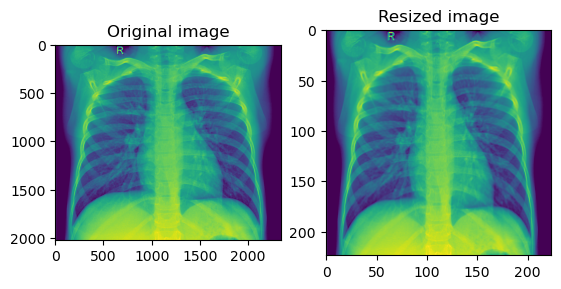

In [25]:
#Test to Choose the size to be used for all x-ray images

#Load the image
image_path = 'C:/Users/sanab/Desktop/chest_xray/train/NORMAL/IM-0183-0001.jpeg'
original_image = Image.open(image_path)

#Define the desired size
#test: 128/150/130/224/180/160...
new_size = (224, 224)

#Resize the image
resized_image = original_image.resize(new_size)

#Display the original and resized images
fig = plt.figure()

#Original image
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(original_image)

# Resized image
plt.subplot(1,2,2)
plt.title('Resized image')
plt.imshow(resized_image)

plt.show()

In [75]:
#Set parameters
target_size = (224,224)
batch_size = 35
#40
class_mode = "binary"
#Data generation objects 
#Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=90, 
    zoom_range = 0.1, 
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True
)

#Create ImageDataGenerator for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Set up data generators using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_path",  # Column containing file paths
    y_col="label",      # Column containing labels
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle = False
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="file_path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle = False
)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


***
# CNN Implementation
***

### Model Creation:

In [27]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2

model_f = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.2),
    
    SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.2),

    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(rate=0.7),
    Dense(units=128, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=64, activation='relu'),
    Dropout(rate=0.3),

    Dense(units=1, activation='sigmoid')
])

### Model Compilation:

In [77]:
model_f.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_f.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 separable_conv2d_32 (Separ  (None, 112, 112, 32)      688       
 ableConv2D)                                                     
                                                                 
 separable_conv2d_33 (Separ  (None, 112, 112, 32)      1344      
 ableConv2D)                                                     
                                                      

### Callbacks Definition:

In [78]:
#Callbacks
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=2, mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=8, mode='min')

### Model Fitting:

In [79]:
import datetime
start = datetime.datetime.now()
#Fitting the model
history = model_f.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[checkpoint,lr_reduce,early_stop]
)
end = datetime.datetime.now()
elapsed = end-start
print ("Time:", elapsed)

Epoch 1/30
 66/118 [===============>..............] - ETA: 1:18 - loss: 0.4642 - accuracy: 0.7749

KeyboardInterrupt: 

### Plot Loss & Accuracy:

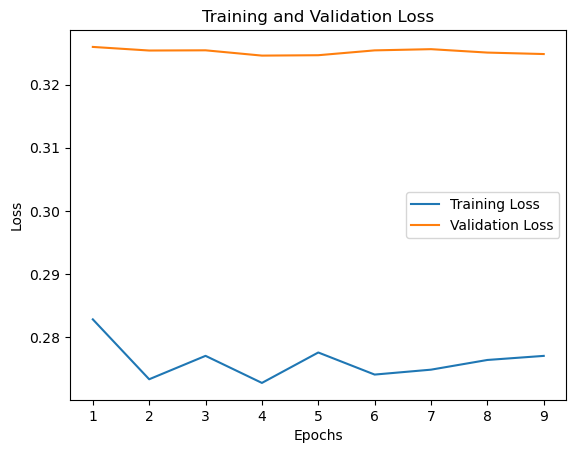

In [68]:
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

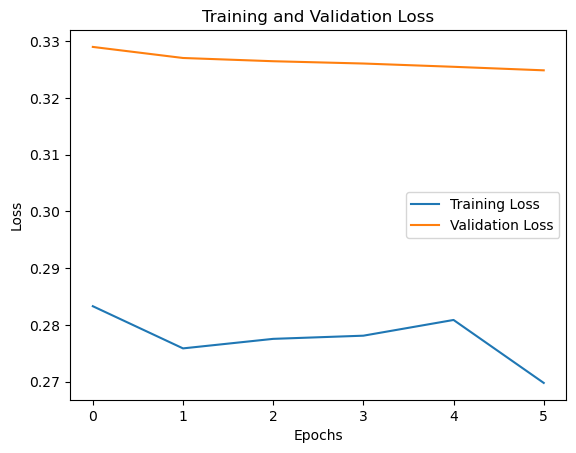

In [61]:
#PLOT 1: LOSS
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

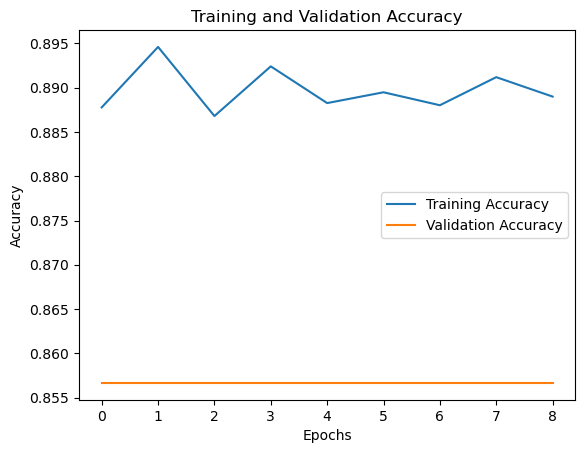

In [69]:
#PLOT 2: ACCURACY
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#load best weights
model_f.load_weights('best_weights.hdf5')

### Model evaluation: 

In [ ]:
#Evaluate the model on the test set
test_loss, test_acc = model_f.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

### Model Saving:

In [ ]:
#Save model
from tensorflow.keras.models import load_model
model_f.save('model_f.keras')

In [ ]:
model_path= 'model_f.keras'
loaded_model_f = load_model(model_path)

***
# Results Achieved 
***

In [ ]:
y_pred = loaded_model_f.predict(test_generator)
threshold = 0.5
y_pred= (y_pred > threshold).astype(int)
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("-"*90)
print("Metrics results Report")
print("-"*90)
print("Precision: {:.2f}%".format(precision * 100))

print("Recall: {:.2f}%".format(recall * 100))

print("F1 Score: {:.2f}%".format(f1 * 100))
print("-"*90)
print("\n\n")

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)
#Plot confusion_matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Normal', 'Pneumonia'], 
                yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print("-"*90)
print("Confusion Matrix Report")
print("-"*90)
tn, fp, fn, tp = conf_matrix.ravel()
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)
print("-"*90)
print("\n\n")

In [ ]:
#Classification Report
from sklearn.metrics import classification_report
class_report = classification_report(y_true, y_pred)
print("-"*90)
print("Classification Report")
print("-"*90)
print(class_report)
print("-"*90)
print("\n\n")

***
# Prediction Test 
***

In [ ]:
import numpy as np
from keras.preprocessing import image
#Load and Preprocess the Image:
img_path = 'C:/Users/sanab/Desktop/chest_xray/test/PNEUMONIA/person1_virus_7.jpeg'
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values between 0 and 1

#Make Predictions
result = loaded_model_f.predict(img_array)
if result[0][0] == 0:
     prediction = 'NORMAL'
else:
     prediction = 'PNEUMONIA'
print ("The prediction result is :",prediction)

In [ ]:
#Load and Preprocess the Image:
img_path = 'C:/Users/sanab/Desktop/chest_xray/test/NORMAL/NORMAL2-IM-0098-0001.jpeg'
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values between 0 and 1

#Make Predictions
result = loaded_model_f.predict(img_array)
if result[0][0] == 0:
     prediction = 'NORMAL'
else:
     prediction = 'PNEUMONIA'
print ("The prediction result is :",prediction)